In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import joblib

# TensorFlow/Keras for LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Download NLTK stopwords if not already downloaded
nltk.download('stopwords')

# Initialize the stemmer and stop words
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))


[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [2]:
# Load the datasets
true_df = pd.read_csv('true.csv')
fake_df = pd.read_csv('fake.csv')

# Add labels: 1 for true news, 0 for fake news
true_df['label'] = 1
fake_df['label'] = 0

# Combine the datasets
data = pd.concat([true_df, fake_df], ignore_index=True)

# Display the shape and first few rows of the data
print(f'Dataset shape: {data.shape}')
print(data.head())


Dataset shape: (44898, 5)
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  label  
0  December 31, 2017       1  
1  December 29, 2017       1  
2  December 31, 2017       1  
3  December 30, 2017       1  
4  December 29, 2017       1  


In [4]:
null_counts = data.isnull().sum()
print(null_counts)

title      0
text       0
subject    0
date       0
label      0
dtype: int64


C:\Users\face\AppData\Local\Temp\ipykernel_13668\1804831249.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="subject", data=data, palette="pastel")


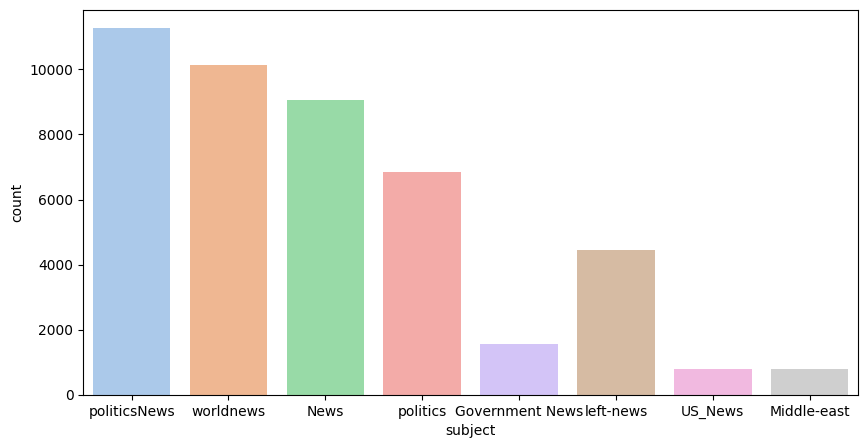

In [24]:
import seaborn as sns
import math
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

ax = sns.countplot(x="subject", data=data, palette="pastel")

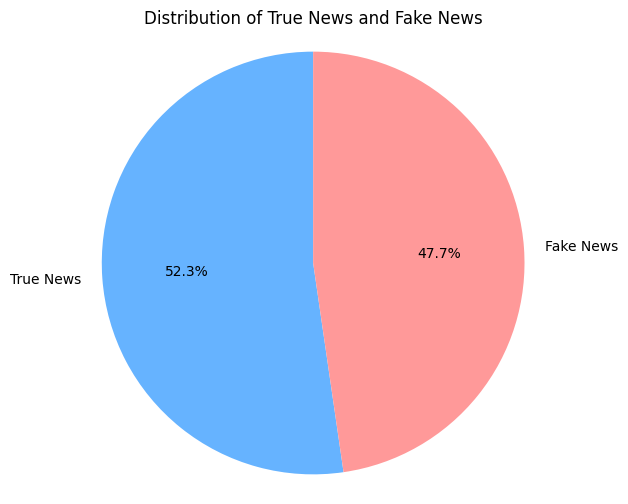

In [25]:
import matplotlib.pyplot as plt

# Count the occurrences of each label
label_counts = data['label'].value_counts()
labels = ['True News', 'Fake News']

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
plt.title('Distribution of True News and Fake News')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [5]:
# Create a cleaned and stemmed corpus
corpus = []
for i in range(0, len(data)):
    # Remove non-alphabetical characters
    review = re.sub('[^a-zA-Z]', ' ', data['text'][i])
    review = review.lower()  # Convert to lowercase
    review = review.split()  # Split into words
    
    # Stem each word and remove stopwords
    review = [ps.stem(word) for word in review if word not in stop_words]
    
    # Join the cleaned words back into a single string
    review = ' '.join(review)
    corpus.append(review)

# Display a few samples from the corpus
print(corpus[:5])


['washington reuter head conserv republican faction u congress vote month huge expans nation debt pay tax cut call fiscal conserv sunday urg budget restraint keep sharp pivot way among republican u repres mark meadow speak cb face nation drew hard line feder spend lawmak brace battl januari return holiday wednesday lawmak begin tri pass feder budget fight like link issu immigr polici even novemb congression elect campaign approach republican seek keep control congress presid donald trump republican want big budget increas militari spend democrat also want proport increas non defens discretionari spend program support educ scientif research infrastructur public health environment protect trump administr alreadi will say go increas non defens discretionari spend percent meadow chairman small influenti hous freedom caucu said program democrat say enough need give govern pay rais percent fiscal conserv see rational eventu run peopl money said meadow among republican vote late decemb parti 

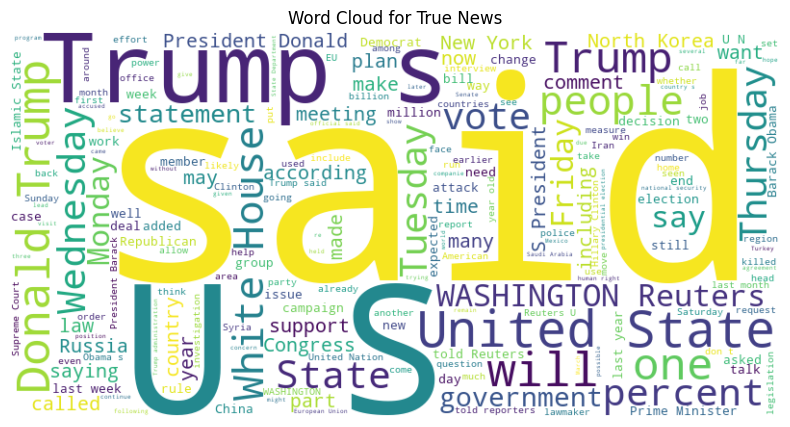

In [28]:
from wordcloud import WordCloud

# Filter the true news articles
true_news_text = ' '.join(data[data['label'] == 1]['text'])

# Generate the word cloud for true news
wordcloud_true = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(true_news_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_true, interpolation='bilinear')
plt.title('Word Cloud for True News')
plt.axis('off')
plt.show()


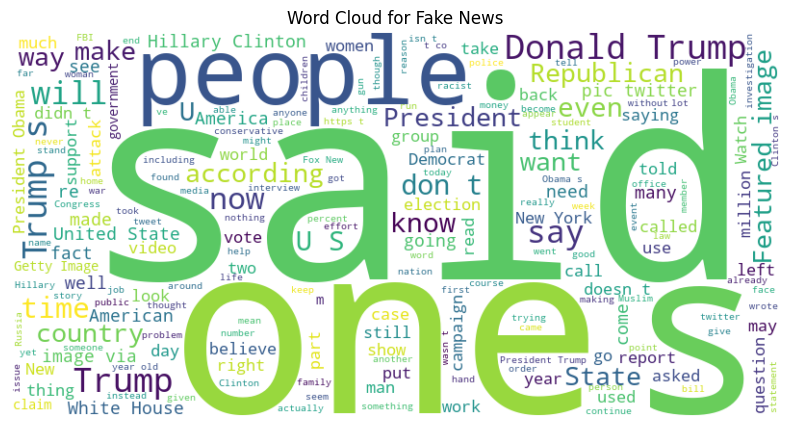

In [29]:
# Filter the fake news articles
fake_news_text = ' '.join(data[data['label'] == 0]['text'])

# Generate the word cloud for fake news
wordcloud_fake = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(fake_news_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.title('Word Cloud for Fake News')
plt.axis('off')
plt.show()


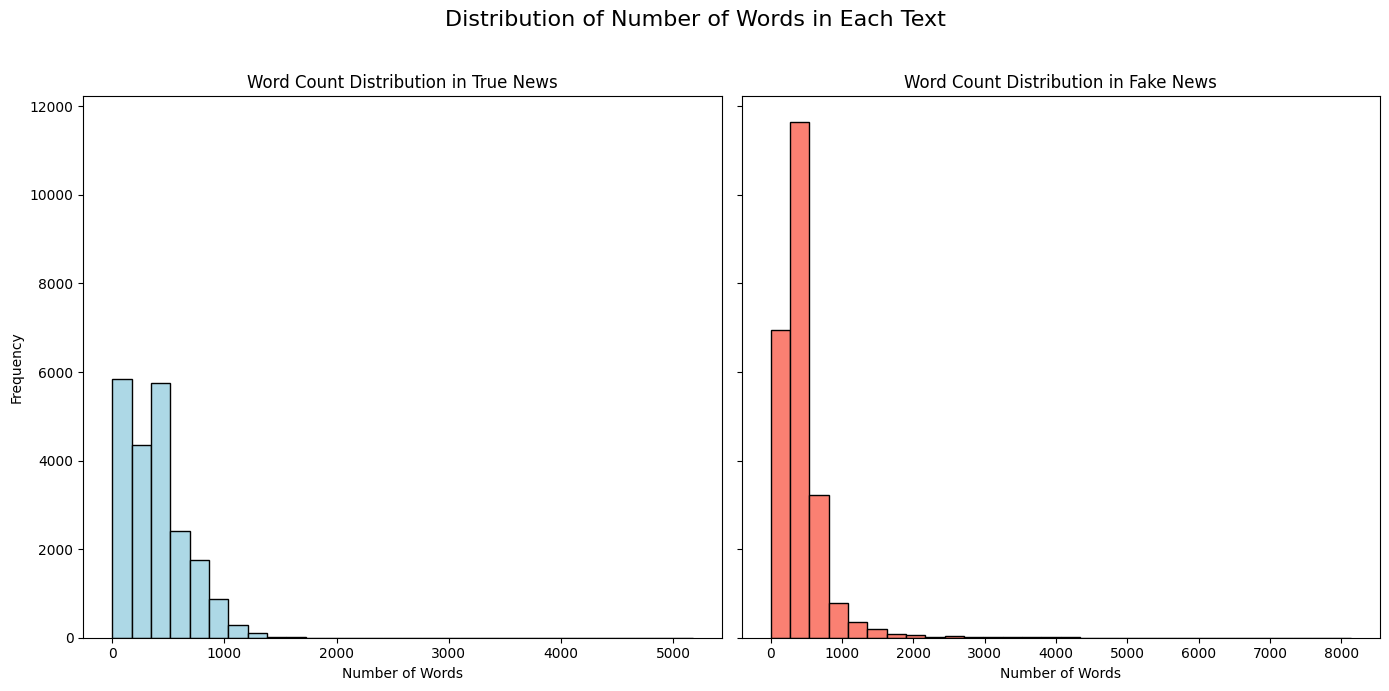

In [31]:
import matplotlib.pyplot as plt

# Calculate the number of words in each article for true news
true_news_word_count = data[data['label'] == 1]['text'].str.split().apply(len)

# Calculate the number of words in each article for fake news
fake_news_word_count = data[data['label'] == 0]['text'].str.split().apply(len)

# Create subplots for side-by-side histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

# Plot the word count distribution for true news
ax1.hist(true_news_word_count, bins=30, color='lightblue', edgecolor='black')
ax1.set_title('Word Count Distribution in True News')
ax1.set_xlabel('Number of Words')
ax1.set_ylabel('Frequency')

# Plot the word count distribution for fake news
ax2.hist(fake_news_word_count, bins=30, color='salmon', edgecolor='black')
ax2.set_title('Word Count Distribution in Fake News')
ax2.set_xlabel('Number of Words')

# Set a common title for the figure
fig.suptitle('Distribution of Number of Words in Each Text', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


In [6]:
# Initialize the TF-IDF Vectorizer
tfidf_v = TfidfVectorizer(max_features=5000, ngram_range=(1,3))

# Transform the corpus into TF-IDF features
X = tfidf_v.fit_transform(corpus).toarray()

# Define labels
y = data['label']

# Split into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Training set size: {X_train.shape}')
print(f'Testing set size: {X_test.shape}')


Training set size: (35918, 5000)
Testing set size: (8980, 5000)


In [7]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Display class distribution after resampling
print('Original training set class distribution:')
print(pd.Series(y_train).value_counts())
print('Resampled training set class distribution:')
print(pd.Series(y_train_resampled).value_counts())


Original training set class distribution:
label
0    18831
1    17087
Name: count, dtype: int64
Resampled training set class distribution:
label
0    18831
1    18831
Name: count, dtype: int64


In [8]:
# Function to train and evaluate a model
def train_and_evaluate_model(model, model_name):
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.4f}")
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    return model

# Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model = train_and_evaluate_model(log_model, "Logistic Regression")

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model = train_and_evaluate_model(rf_model, "Random Forest")

# Support Vector Machine (SVM)
svm_model = SVC(kernel='linear', random_state=42)
svm_model = train_and_evaluate_model(svm_model, "Support Vector Machine")


Logistic Regression Accuracy: 0.9898
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4650
           1       0.99      0.99      0.99      4330

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

Random Forest Accuracy: 0.9971
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4650
           1       1.00      1.00      1.00      4330

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

Support Vector Machine Accuracy: 0.9952
Support Vector Machine Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4650
   

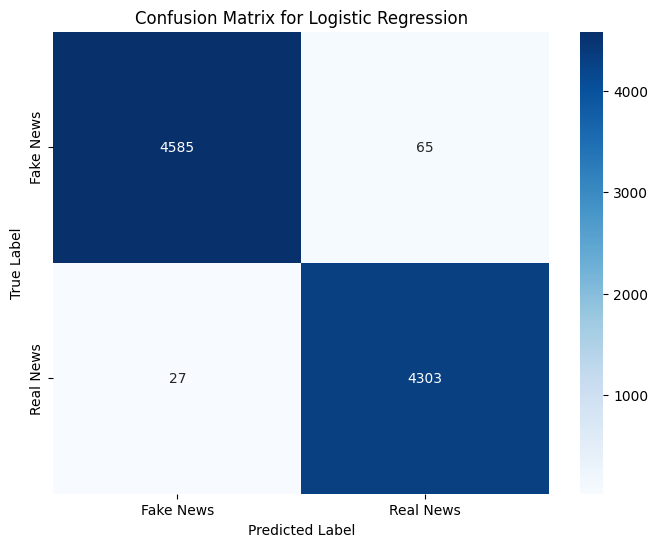

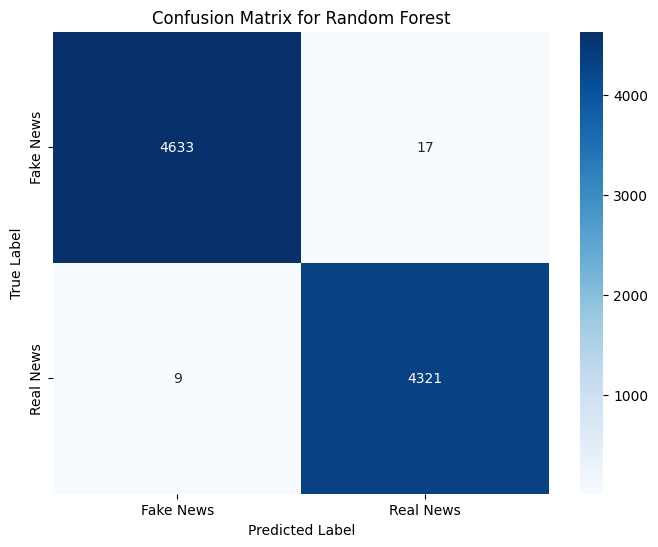

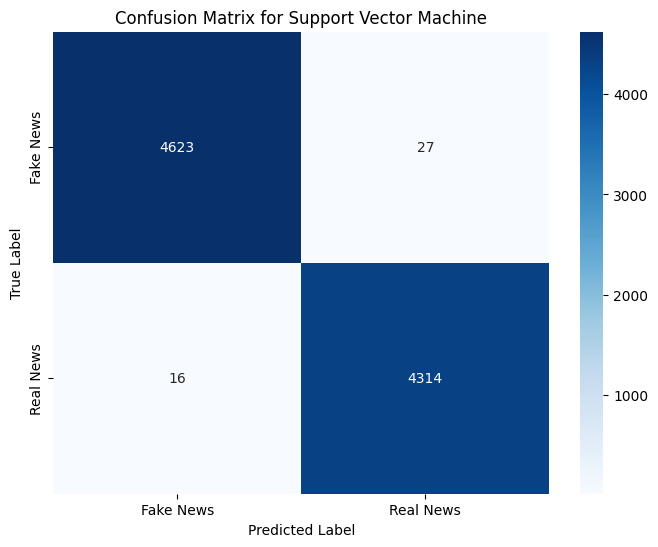

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake News', 'Real News'], yticklabels=['Fake News', 'Real News'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Logistic Regression Confusion Matrix
y_pred_log = log_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred_log, "Logistic Regression")

# Random Forest Confusion Matrix
y_pred_rf = rf_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")

# Support Vector Machine (SVM) Confusion Matrix (if you want to include this as well)
y_pred_svm = svm_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred_svm, "Support Vector Machine")


In [30]:
# Function to preprocess and predict a single news article
def predict_news(model, news_text):
    # Clean the input text
    review = re.sub('[^a-zA-Z]', ' ', news_text)
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if word not in stop_words]
    clean_news = ' '.join(review)
    
    # Transform using the TF-IDF vectorizer
    tfidf_news = tfidf_v.transform([clean_news])
    
    # Predict and return the result
    prediction = model.predict(tfidf_news)
    return 'Real News' if prediction[0] == 1 else 'Fake News'

# Test the prediction function with a sample input
sample_news = data['text'].iloc[0]  # Replace with any news article for testing
print(f'Sample News: {sample_news}')
print(f'Prediction: {predict_news(log_model, sample_news)}')

Sample News: WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that su